<a href="https://colab.research.google.com/github/Gnow-git/YoutubeCommentSentimentAnalysis/blob/main/kobert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

환경설정

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!export TORCH_CUDA_ARCH_LIST=8.6
!pip install transformers==4.8.1
!pip install torch


In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [46]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import torch
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#GPU 사용
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/Mecab-ko-for-Google-Colab/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/Mecab-ko-for-Google-Colab/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [114]:
import re
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


전처리

In [115]:
anno = []
result = []
rate = {
    "강긍정" : 5,
    "약긍정" : 4,
    "부분긍정" : 3,
    "부분부정" : 3,
    "약부정" : 2,
    "강부정" : 1
}

# print(total_data)

with open ("/content/sample_data/annotations.json", encoding="utf-8") as f:
    dict = json.load(f)
    examples = dict["examples"]
    for jsons in examples:
        if(len(jsons['annotations']) != 0):
            anno.append(jsons)

    for annotation in anno:
        for tag in annotation['annotations']:
            newJson = {
                'ratings': rate[tag['tag']],
                'reviews': tag['value']
            }
            result.append(newJson)

    finalresult = json.dumps(result)

    chatbot_data_youtube = pd.DataFrame(result)

In [182]:
# 네이버 쇼핑 리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

# 열제목 'ratings', 'review' 추가
chatbot_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

In [183]:
total_data = pd.concat( [chatbot_data, chatbot_data_youtube] )

print('전체 리뷰 개수 : ', len(total_data))

전체 리뷰 개수 :  200714


In [184]:
total_data.sample(n=10)

,ratings,reviews
24533,5,좋음 ㅎㅎ.....
21604,5,크기도 적당하고 배송도 엄청 빨라서 좋았어요^-^무엇보다 설치하는것도 정말 쉬워서 ...
39792,5,붙이기 간편하고 아주 좋습니다
157503,1,같이 주문한 연어는 맛있었지만... 광어는 정말 실망입니다.. 살이 허벅허벅하고 비...
112230,2,배송이 거의 일주일 가까이가 걸리네용... 전구도 누락되고... 내용물은 이쁩니다...
46784,2,그냥 행거하려다 선반했는데 행거할껄그랫어요
19348,2,하의는 정사즈인데 상의는 너무크네요 전체적으로 팔기장도 수선할수없게끔 단추타입에 안...
4330,2,생각보다 사이즈 작아요 별로 도움 안 되는 듯
124105,5,저렴하게 샀습니다:)
9684,5,한달써도 만족해요. 옷 많이 튼튼하게 잘 버텨주네요.


감정 단어 숫자로 변경

In [185]:
chatbot_data.loc[(chatbot_data['ratings'] == 2), 'ratings'] = 1  #복합적 => 3
chatbot_data.loc[(chatbot_data['ratings'] == 3), 'ratings'] = 2  #복합적 => 3
chatbot_data.loc[(chatbot_data['ratings'] == 4), 'ratings'] = 2  #약부정 => 1
chatbot_data.loc[(chatbot_data['ratings'] == 5), 'ratings'] = 3  #강부정 => 1

chatbot_data.sample(n=1000)

,ratings,reviews
126728,1,한달 사용만에 손잡이가 파손되었어요 문자로 파손 손잡이 사진 보내드렸는데 이렇다 저...
110170,3,재구매 두번쩨 구이입니다 너무 맘에들어요
116255,2,기사님도 친절하시고 엄마랑 둘이 여행했는데 알차게 편하게 돌아다녔습니다. 다음에는 ...
159200,3,한달 사용기입니다. 아직도 싱싱하게 잘 자라고 있습니다. 저렴하게 잘 구매했습니다....
4752,3,아직 사용은 해보지 않았지만 별 탈없이 잘 되리라 믿습니다!
...,...,...
101533,1,입으면 색이나 목부분은 이쁜데 덩치가 엄청 커보여요
20199,1,혼자서 붙이는게 쉬운게 아니네요
67146,1,큐알하고 결합어 문제있습니다
159955,1,잘사용하겠습니다수고하세요


In [186]:
#total_data['label'] = np.select([total_data.ratings > 3, total_data.ratings == 3, total_data.ratings < 3], [2, 1, 0])
#total_data[:10]

데이터셋 일부 출력

In [187]:
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[24000])
print(data_list[30000])
print(data_list[-1])

['배공빠르고 굿', '2']
['머릿결 끝이 거의 타다시피해서 엄청 개톨이엿는데 이거 발랏을때는 좀 부드러워지는것 같아요 끈적임도 없고 ㅎㅎ본품은 아직 개봉전이고 샘플 사용중인데 좋은거 같아요', '1']
['넘좋으네요 이걸로 파데로썼는데괜찮네요', '1']
['상품을받아서 뚜껑을 열었더니 이렇게 띁어져있네요~ 제품엔 이상없는거같고 반품귀찮아서 그냥먹긴 하겠는데 잘좀확인하시고 보내주세요~~ 이런경우는 첨이라 당황스럽네요~~', '1']
['시간지나면 건조해요', '1']
['울냥이들은 성격이 급해 사료나오는곳만 보네요 바보들~~조만간 이해하겠죠', '1']
['휴대성은 확실히 좋아요', '2']


Train data & Test data 나누기

In [200]:
#train & test 데이터로 나누기                                   
dataset_train, dataset_test = train_test_split(chatbot_data, test_size=0.25, random_state=42)

In [201]:
print('훈련용 리뷰 개수 :', len(dataset_train))
print('테스트용 리뷰 개수 :', len(dataset_test))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


   ratings  count
0        1  75076
1        2  14063
2        3  60861


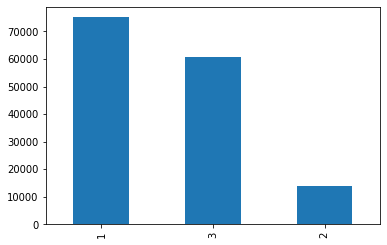

In [202]:
#레이블 분포 확인
dataset_train['ratings'].value_counts().plot(kind = 'bar')
print(dataset_train.groupby('ratings').size().reset_index(name = 'count'))

In [203]:
# 한글과 공백을 제외하고 모두 제거
dataset_train['reviews'] = dataset_train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
dataset_train['reviews'].replace('', np.nan, inplace=True)
print(dataset_train.isnull().sum())

<ipython-input-203-9d1332d04431>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_train['reviews'] = dataset_train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
dtype: int64


In [204]:
dataset_test.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
dataset_test['reviews'] = dataset_test['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
dataset_test['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
dataset_test = dataset_test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(dataset_test))

전처리 후 테스트용 샘플의 개수 : 49995


<ipython-input-204-54e4608eea3f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset_test['reviews'] = dataset_test['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [205]:
mecab = Mecab()
print(mecab.morphs('상품을받아서 뚜껑을 열었더니 이렇게 띁어져있네요'))

['상품', '을', '받', '아서', '뚜껑', '을', '열', '었', '더니', '이렇', '게', '띁어져있네요']


KoBERT 입력데이터 만들기

In [194]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

하이퍼 파라미터 설정

In [195]:
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [196]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/Mecab-ko-for-Google-Colab/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


ValueError: ignored

In [ ]:
data_train[0]

torch 형식 dataset 만들기

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

kobert 학습모델 만들기

num_classes = 다중분류할 클래스 수

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=3,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
!pip install git+https://github.com/deepset-ai/haystack.git
!pip install farm-haystack

In [ ]:
criterion=nn.BCEWithLogitsLoss()
criterion=nn.BCELoss()
CUDA_LAUNCH_BLOCKING = "1"
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

kobert 모델 학습시키기

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))


In [ ]:
torch.save(model, 'model.pt')

In [ ]:
torch.save(model.state_dict(), 'model1.pt')

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
history = torch.load('/content/drive/MyDrive/model.pt')

In [ ]:
def learning_curve(history, num_epochs):
  plt.figure(figsize=(10,5))
  # 정확도 차트  
  epoch_range = np.arange(1, num_epochs + 1)

  plt.subplot(1, 2, 1)

  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel("Accurach")
  plt.legend( ['Train', 'Val']  )
  # plt.show()

  # loss 차트
  plt.subplot(1, 2, 2)

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel("Loss")
  plt.legend( ['Train', 'Val']  )

  plt.show()

In [ ]:
learning_curve(history, 5)

새로운 문장 테스트

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 1:
                test_eval.append("부정이")
            elif np.argmax(logits) == 3:
                test_eval.append("복합적인 감정이")
            elif np.argmax(logits) == 5:
                test_eval.append("강한 긍정이")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    predict(sentence)
    print("\n")